# Word Plots For Top 20 Words

Helpful reads:

- https://textminingonline.com/dive-into-nltk-part-iv-stemming-and-lemmatization
- https://blog.altoros.com/using-k-means-clustering-in-tensorflow.html
- http://brandonrose.org/clustering
- https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229
- http://ai.intelligentonlinetools.com/ml/convert-word-to-vector-glove-python/

Links specific to Textblob:

- https://textblob.readthedocs.io/en/dev/quickstart.html#wordnet-integration
- http://www.nltk.org/howto/wordnet.html
- https://stevenloria.com/wordnet-tutorial/

First thing to do is load in the words from the .csv file into an array called `words`.

In [20]:
# Preambe
%matplotlib inline
import sys
import pickle
import numpy as np
from matplotlib import pyplot
import warnings
import plotly as py
import plotly.graph_objs as go
from math import sqrt
py.offline.init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')

In [2]:
words = [] # This will contain a list of the top 20 words

def load_words_from_file():
    "Load the words from .csv file"
    global words

    with open("data/inference_words.csv", "r") as file:
        content = file.readlines()
    for line in content:
        line_list = line[:-1].split(',')
        words.append(line_list)
    print('Loaded {} lines from the .csv file.'.format(len(words)))
    # Go ahead and Pickle the words for later use
    with open("models/inference_words.pickle", "wb") as pickle_file:
        pickle.dump(words, pickle_file)
        print("Pickle file created")

def load_words_from_pickle():
    "Load the words from .pickle file"
    global words

    with open("models/inference_words.pickle", "rb") as pickle_file:
        words = pickle.load(pickle_file)
        print('Loaded {} lines from the .pickle file.'.format(len(words)))

#load_words_from_file()
load_words_from_pickle()

Loaded 823 lines from the .pickle file.


### The (naive) model:

This is just the starting point model which is trained on the list of top 20 words. Since the words in the top 20 list aren't complete sentences, it can't be expected that this will produce the best result. We will use the list of top 20 words to train a PCA model. This will then be used for the visualization.

In [7]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

def create_naive_model(min_count = 5):
    "Creates the naive model"
    global model
    model = Word2Vec(words, min_count=5) # Change min_count to 1 to get every occurance
    # Save the model
    model.save("models/simple_model.bin")
    # Print summary about model
    print(model)

def load_model(path = "models/simple_model.bin"):
    "Load a model given a path"
    global model
    model = Word2Vec.load(path)
    print(model)
    
load_model()

Word2Vec(vocab=548, size=100, alpha=0.025)


### Visualization for the naive model:
Now that a brief model has been created for the words (via word2vec) and saved as a file called `model.bin` we can focus on trying to get the visualization. 

**Note** that the colors of the data points do not actually have any significance. I have only colored them so that it is easier to distinguish points.

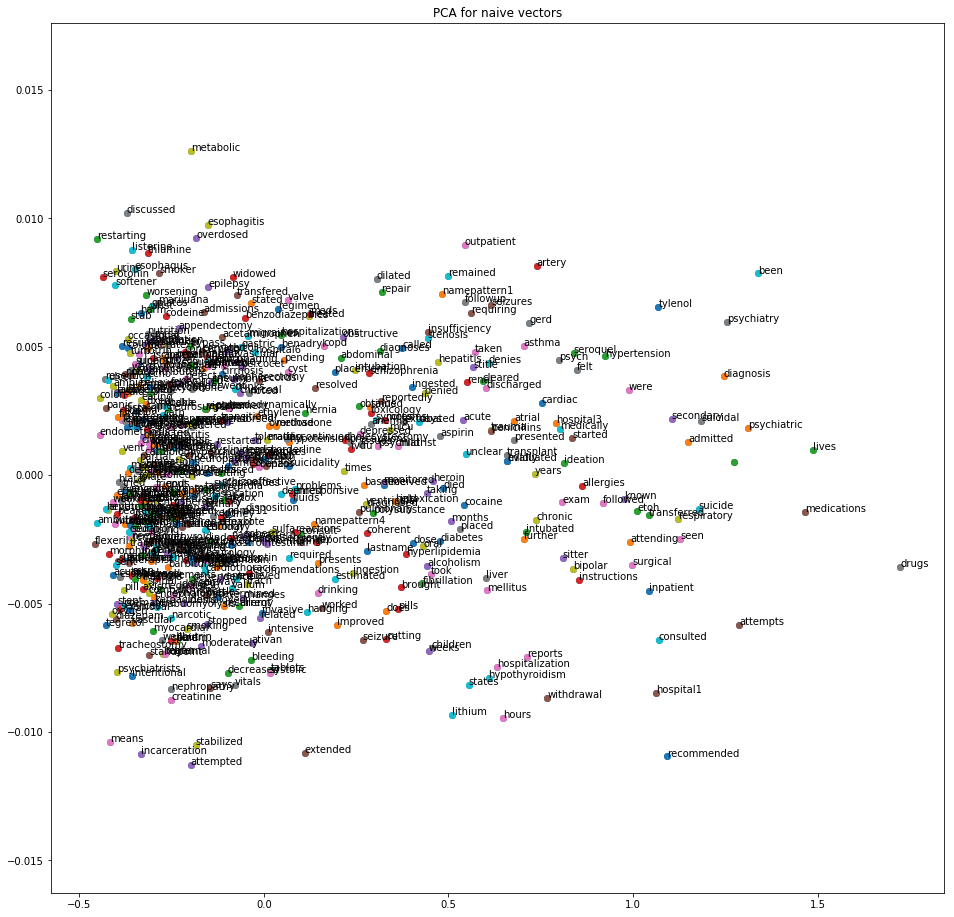

In [8]:
def create_naive_plot(save=False):
    "Create plot for the naive model"
    global model
    global model_words # Just a list of our vocab, useful for future models
    vectors = model[model.wv.vocab]
    pca = PCA(n_components=2, random_state=23)
    result = pca.fit_transform(vectors)
    
    # Create the plot
    plot = pyplot.figure(figsize=(16, 16))
    pyplot.title("PCA for naive vectors")
    pyplot.scatter(result[:, 0], result[:, 1])
    
    model_words = list(model.wv.vocab)
    
    # Save out the model_words, only if save is true
    if save:
        with open("models/model_words.pickle", "wb") as pickle_file:
            pickle.dump(model_words, pickle_file)
    
    for i, word in enumerate(model_words):
        pyplot.scatter(result[i, 0], result[i, 1])
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
        
    pyplot.show()
    
    # Save a .png of the plot
    plot.savefig("output/naive_plot.png")

create_naive_plot()

In [4]:
def load_model_words():
    "Load a model_words"
    global model_words
    with open("models/model_words.pickle", "rb") as pickle_file:        
        model_words = pickle.load(pickle_file)
    print("model_words loaded")

load_model_words()

model_words loaded


### Using the embeddings for the PCA:

Instead of just using the 20 words list to get the word vectors, it would be more benficial to use the actual embedder used to train on the data to produce the plots. This is where `data/embedder` comes into play. Here we use the pretrained word2vec embedding to infer specific words from the top 20 list.

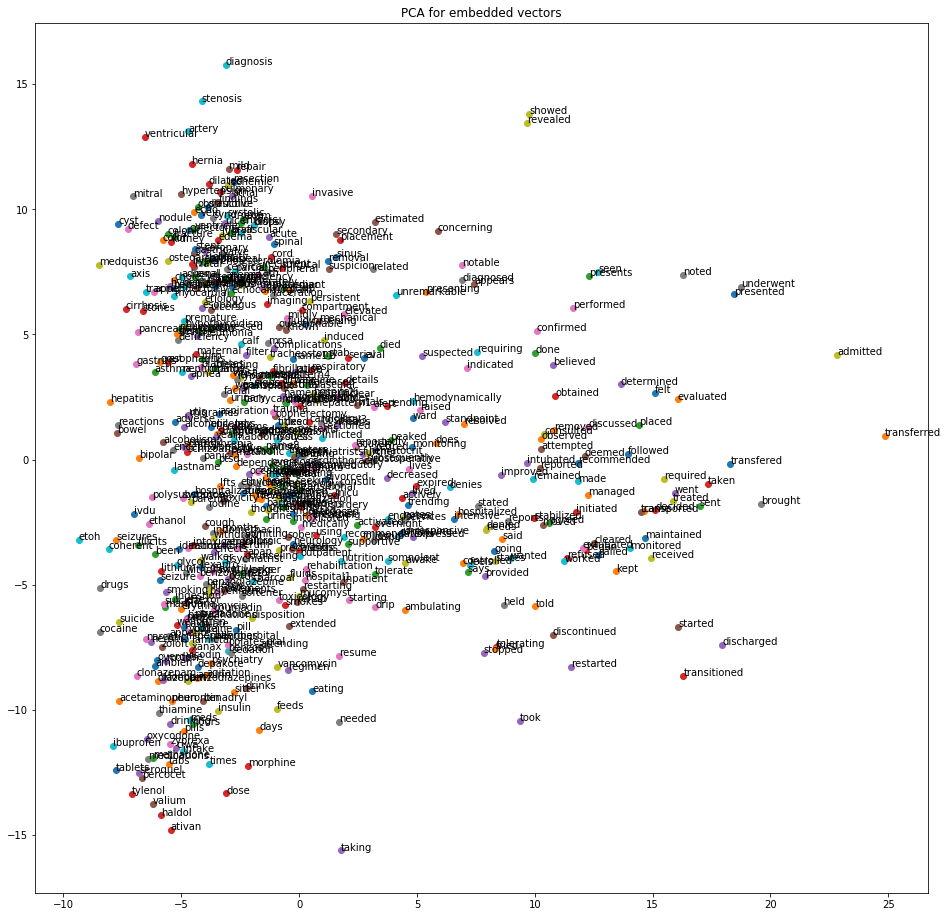

In [60]:
def create_embedded_plot(save=False):
    "Import the model from the folder and then create the plot for it"
    global emb_model
    emb_model = Word2Vec.load("data/embedder/processed_full.w2v")
    vectors = emb_model[sorted(model_words)[1:]]
    pca = PCA(n_components=2, random_state=23)
    result = pca.fit_transform(vectors)
    
    global pca_emb_result
    pca_emb_result = result

    # Make the plot:
    plot = pyplot.figure(figsize=(16, 16)) 
    pyplot.title("PCA for embedded vectors")

    for i, word in enumerate(sorted(model_words)[1:]):
        pyplot.scatter(result[i, 0], result[i, 1])
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))

    pyplot.show()
    
    # Save a .png of the plot
    if save:
        plot.savefig("output/embedded_plot.png")

create_embedded_plot()

## TSNE approach:

Instead of using PCA we can also use a [T-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) approach to try and reduce the dimensionality of the embedded word vectors.

- https://alexanderfabisch.github.io/t-sne-in-scikit-learn.html
- https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne

In [6]:
from sklearn.manifold import TSNE

def tsne_model(model, perplexity=40):
    "Create the t-SNE model"
    global new_values
    
    tokens = []
    
    for word in sorted(model_words)[1:]:
        tokens.append(model[word])
    
    tsne_model = TSNE(perplexity=perplexity, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    # Save the model
    with open("models/tsne_model.pickle", "wb") as pickle_file:
        pickle.dump(tsne_model, pickle_file)
    
    # Save the new_values
    with open("models/tsne_new_values.pickle", "wb") as pickle_file:
        pickle.dump(new_values, pickle_file)
    
    print("Created a t-SNE model and saved it to the models/ folder")
    
def load_tsne_new_values():
    "Loads the t-SNE model from the models folder"
    global new_values

    with open("models/tsne_new_values.pickle", "rb") as pickle_file:        
        new_values = pickle.load(pickle_file)
        
    print("Loaded the new_values from the .pickle file.")
    
load_tsne_new_values()
#tsne_model(emb_model)

Loaded the new_values from the .pickle file.


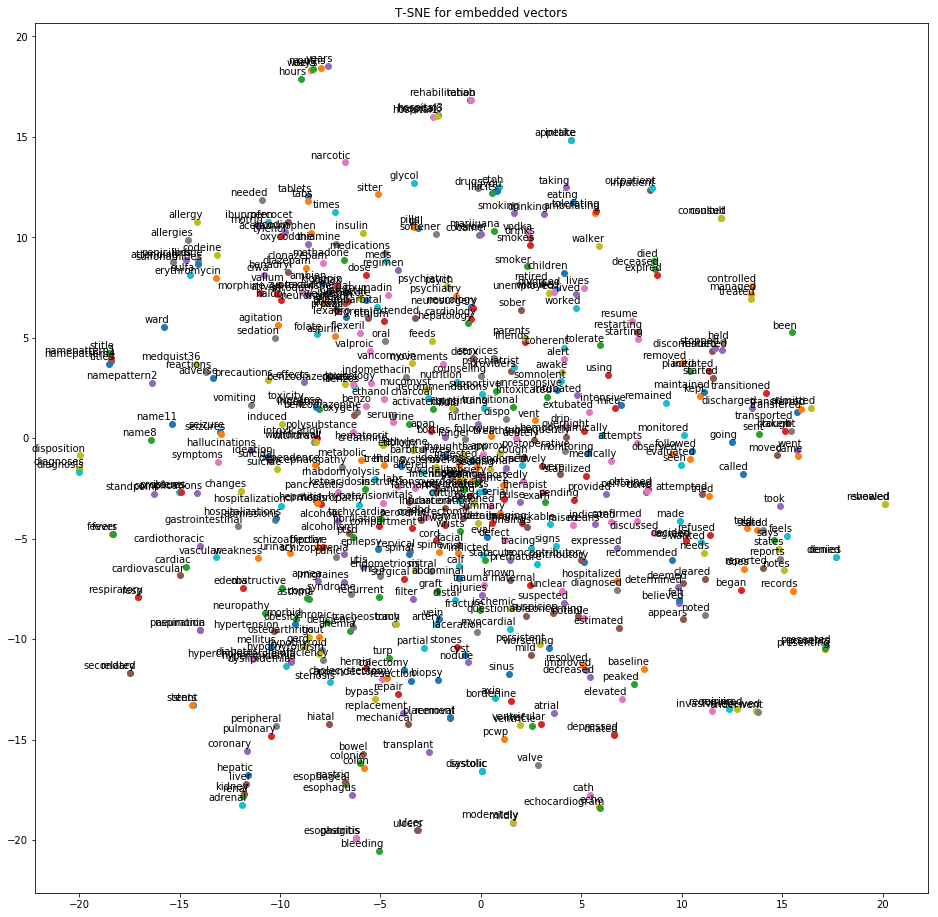

In [23]:
def tsne_plot(save=False):
    "Creates the t-SNE plot"
    labels = []

    for word in sorted(model_words)[1:]:
        labels.append(word)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plot = pyplot.figure(figsize=(16, 16))
    pyplot.title("T-SNE for embedded vectors")
    for i in range(len(x)):
        pyplot.scatter(x[i],y[i])
        pyplot.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    pyplot.show()
    # Save a .png of the plot
    if save:
        plot.savefig("output/tsne_embedded_plot.png")

tsne_plot()

## Interactive Plots

In order to get a much better understanding of the plots, it would be ideal to use an interactive plotting library. That would allow us to use not only ~500 of the most popular words on the top 20 list, but also use all ~3400 or so words from the top 20 list. I also believe the groupings will be made more clear

##### t-SNE interactive plot:

In [7]:
def tsne_interactive_plot(save=False, show_labels=False):
    "Creates the t-SNE interactive plot"
    labels = []
    data = []

    for word in sorted(model_words)[1:]:
        labels.append(word)

    x = []
    y = []
    
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    # Should we show markers / markers & text
    if show_labels:
        mode = "markers+text"
    else:
        mode = "markers"

    for i in range(len(x)):
        trace0= go.Scatter(
            x= [x[i]],
            y= [y[i]],
            mode= mode,
            text= labels[i],
            textposition='top center')
        data.append(trace0);
    
    # Save the html file 
    if save:
        plotly.offline.plot({
            "data": data, 
            "layout": go.Layout(title="T-SNE for Embedded Vectors for {} words".format(len(model_words)), 
                            showlegend=False)
        }, auto_open=False, filename="output/tsne-interactive-plot.html")

    py.offline.iplot({
        "data": data, 
        "layout": go.Layout(title="T-SNE for Embedded Vectors for {} words".format(len(model_words)), 
                            showlegend=False)
    })

tsne_interactive_plot()

##### PCA interactive plot:

In [61]:
def pca_interactive_plot(save=False, show_labels=False):
    "Creates the PCA interactive plot"
    labels = []
    data = []

    x = []
    y = []
    
    for i, word in enumerate(sorted(model_words)[1:]):
        x.append(pca_emb_result[i, 0])
        y.append(pca_emb_result[i, 1])
        labels.append(word)

    # Should we show markers / markers & text
    if show_labels:
        mode = "markers+text"
    else:
        mode = "markers"
        
    for i in range(len(x)):
        trace0= go.Scatter(
            x= [x[i]],
            y= [y[i]],
            mode= mode,
            text= labels[i],
            textposition='top center')
        data.append(trace0);
    
    # Save the html file 
    if save:
        plotly.offline.plot({
            "data": data, 
            "layout": go.Layout(title="PCA for embedded vectors for {} words".format(len(model_words)), 
                            showlegend=False)
        }, auto_open=False, filename="output/pca-interactive-plot.html")

    py.offline.iplot({
        "data": data, 
        "layout": go.Layout(title="PCA for embedded vectors {} words".format(len(model_words)), 
                            showlegend=False)
    })
        

pca_interactive_plot()

## Heatmaps

It would be interesting to see heatmaps for both the PCA and t-SNE models. Perhaps there are specific regions where points are more likely to popup.

In [ ]:
def pca_heatmap(save=False, bins=100):
    "Create the heatmap for the PCA dataset"
    x = pca_emb_result[:, 0]
    y = pca_emb_result[:, 1]

    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    plot = pyplot.figure(figsize=(16, 16))
    pyplot.clf()
    pyplot.title("Heatmap for PCA")
    pyplot.imshow(heatmap.T, extent=extent, origin='lower')
    pyplot.show()
    
    # Save a .png of the plot
    if save:
        plot.savefig("output/pca_heatmap.png")

pca_heatmap()

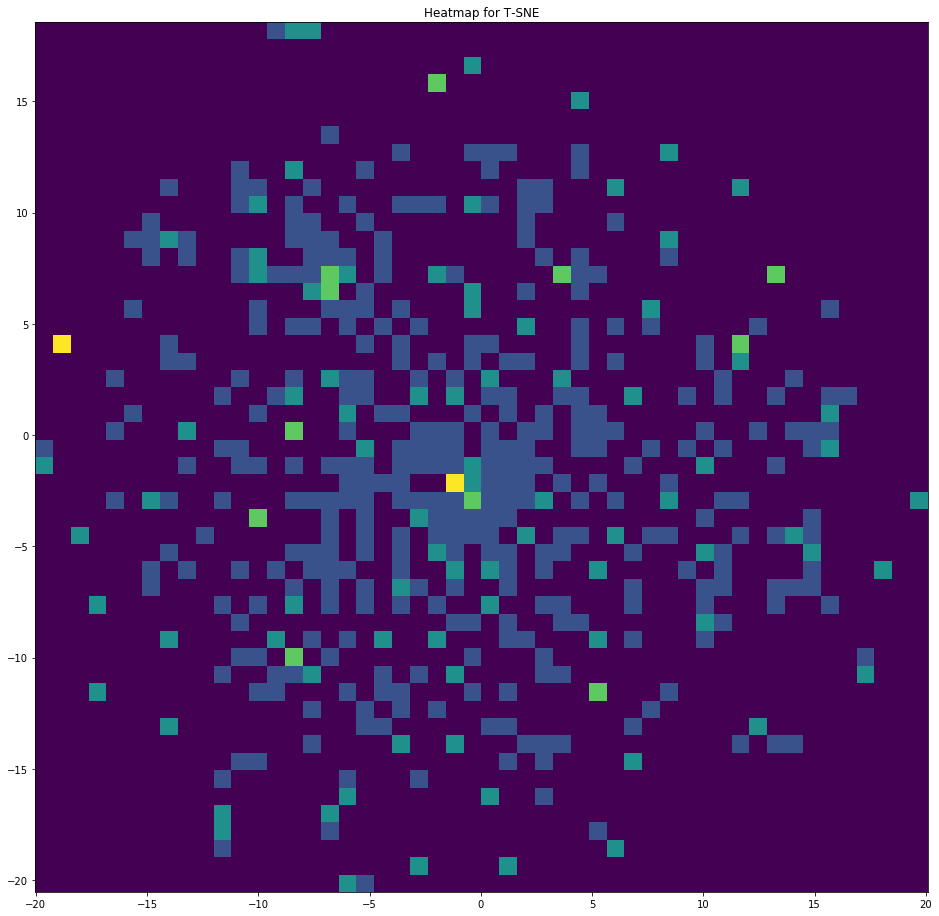

In [85]:
def tsne_heatmap(save=False, bins=50):
    "Create the heatmap for the t-SNE dataset"
    x = new_values[:, 0]
    y = new_values[:, 1]
    
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    plot = pyplot.figure(figsize=(16, 16))
    pyplot.clf()
    pyplot.title("Heatmap for T-SNE")
    pyplot.imshow(heatmap.T, extent=extent, origin='lower')
    pyplot.show()
    
    # Save a .png of the plot
    if save:
        plot.savefig("output/tsne_heatmap.png")

tsne_heatmap()

### Close-ness Maps

Rather than a spacial heatmap, it would be interesting to see an interactive heatmap similar to a correlation heatmap which shows the distance between two words. If two words were closer, then their distance would be low, and if the words were far apart then the distance would be high. 

In [64]:
# Get distances for each word to word combination
def tsne_distances():
    "Get the distances between different points"
    words = sorted(model_words)[1:]
    distances = np.empty([len(words), len(words)])
    dist = lambda p1,p2: sqrt(((p2[0]-p1[0])**2)+((p2[1]-p1[1])**2))
    
    # For all the words, generate the the distance plot:
    for index, word in enumerate(words):
        for index2, word2 in enumerate(words):
            distances[index][index2] = dist(new_values[index], new_values[index2])
    
    return words, distances

def distance_plot(save=False):
    "Create a heatmap correlation style map for a given set of words"
    words, distances = tsne_distances()
    fig = pyplot.figure(figsize=(16, 16))
    ax = fig.add_subplot(111)
    cax = ax.matshow(distances, vmin=np.min(distances), vmax=np.max(distances))
    fig.colorbar(cax)
    ticks = np.arange(0,len(words),1)
    ax.axis('off')
    #ax.set_xticks(ticks)
    #ax.set_yticks(ticks)
    #ax.set_xticklabels(words)
    #ax.set_yticklabels(words)
    pyplot.show()
    
    # Save a .png of the plot
    if save:
        fig.savefig("output/closeness-map.png")



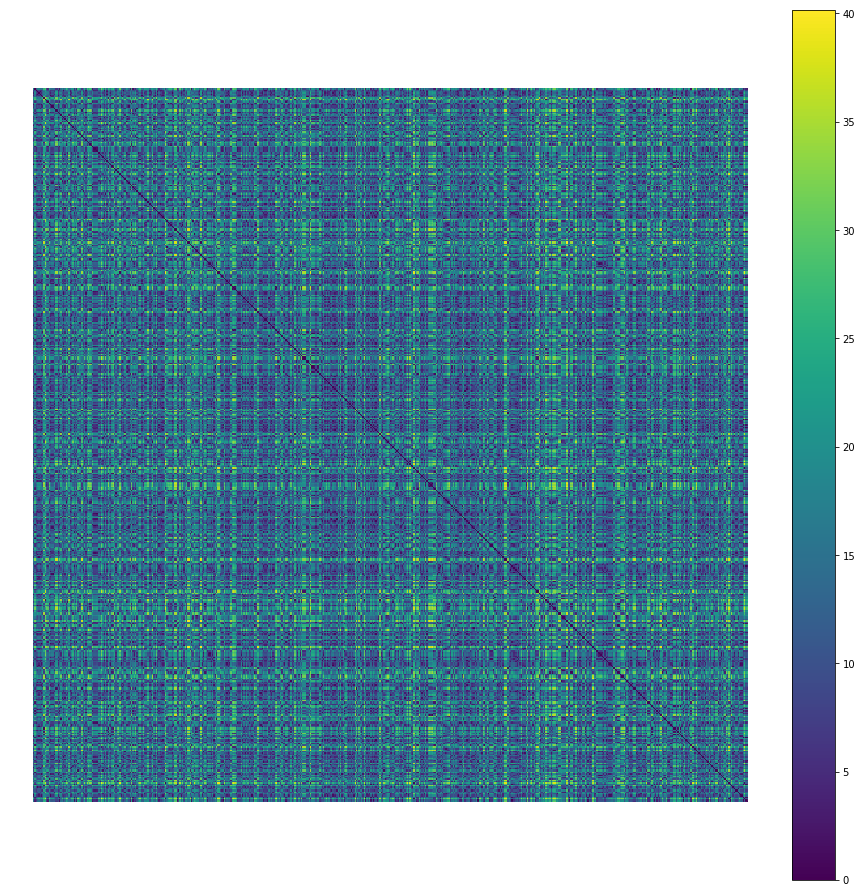

In [66]:
distance_plot(save=True)

In [73]:
words, dist = tsne_distances()


40.15675435984351

In [74]:
print(np.mean(dist))
print(np.median(dist))
print(np.max(dist))

14.741479394955935
14.111731963740338
40.15675435984351
